# Image Matching

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
from scipy.spatial import cKDTree
from skimage.feature import plot_matches
from skimage.measure import ransac
from skimage.transform import AffineTransform
from six import BytesIO
import tensorflow as tf
import tensorflow_hub as hub
from six.moves.urllib.request import urlopen
import cv2
import imutils
import glob
import os
from itertools import accumulate
import sys
sys.path.append('/home/tung/playground/delf_instance_retrieval/delf/delf/python/examples/')
#sys.path.append('/home/tung/playground/delf_instance_retrieval/delf/delf/python/')

from utils import download_and_resize_image, resize_image, show_images, image_input_fn, match_images
import extract_features
from scipy.spatial import cKDTree
from skimage.measure import ransac
from skimage.transform import AffineTransform
from skimage.feature import plot_matches

from delf import feature_io

_DISTANCE_THRESHOLD = 0.8

np.random.seed(10)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




In [ ]:
#!pip install scikit-image
#!pip install tensorflow-hub
#!pip install opencv-python
#!pip install imutils

In [ ]:
#tf.logging.set_verbosity(tf.logging.INFO)

## Match an image pair

In [17]:
image_1_path = '/home/tung/playground/data/oxford5k/oxford5k_images/all_souls_000005.jpg'# oxford_000317.jpg'
#features_1_path = '/home/tung/playground/data/oxford5k/oxford5k_features/oxford_000317.delf' #oxford_000773.delf'
features_1_path = image_1_path.replace('images', 'features').replace('jpg', 'delf')

image_2_path = '/home/tung/playground/data/oxford5k/oxford5k_images/hertford_000056.jpg'
#features_2_path = '/home/tung/playground/data/oxford5k/oxford5k_features/hertford_000056.delf'
features_2_path = image_2_path.replace('images', 'features').replace('jpg', 'delf')
features_2_path

'/home/tung/playground/data/oxford5k/oxford5k_features/hertford_000056.delf'

In [18]:
# Read features.
locations_1, _, descriptors_1, _, _ = feature_io.ReadFromFile(features_1_path)
num_features_1 = locations_1.shape[0]
tf.logging.info("Loaded image 1's %d features" % num_features_1)
locations_2, _, descriptors_2, _, _ = feature_io.ReadFromFile(features_2_path)
num_features_2 = locations_2.shape[0]
tf.logging.info("Loaded image 2's %d features" % num_features_2)

INFO:tensorflow:Loaded image 1's 908 features
INFO:tensorflow:Loaded image 2's 1000 features


In [19]:
# Find nearest-neighbor matches using a KD tree.
d1_tree = cKDTree(descriptors_1)
_, indices = d1_tree.query(
  descriptors_2, distance_upper_bound=_DISTANCE_THRESHOLD)

In [35]:
indices

array([908, 908, 455, 908, 908, 908, 908, 908, 908, 908, 908, 908, 908,
       908, 542, 908, 758, 908, 908, 908, 908, 908, 908, 443, 908, 908,
       908, 908, 908, 908, 908, 908, 908, 908, 908, 908, 432, 655, 908,
       655, 908, 655, 908, 908, 908, 908, 908, 908, 908, 908, 908, 908,
       738, 908, 908, 908, 908, 908, 908, 908, 323, 908, 908, 908, 908,
       625, 908, 832, 908, 322, 908, 908, 657, 782, 908, 908, 908, 908,
       908, 908, 908, 462, 908, 908, 908, 908, 908, 908, 908, 908, 908,
       908, 908, 758, 655, 908, 908, 908, 908, 908, 758, 908, 908, 908,
       655, 908, 908, 908, 655, 655, 908, 908, 908, 908, 908, 908, 908,
       908, 908, 908, 524, 876, 908, 908, 908, 908, 908, 908, 908, 908,
       908, 908, 908, 655, 908, 908, 908, 908, 908, 908, 758, 908, 908,
       908, 908, 908, 908, 908, 655, 908, 908, 908, 908, 908, 908, 908,
       908, 908, 908, 908, 908, 908, 908, 908, 908, 908, 542, 908, 655,
       908, 908, 462, 462, 908, 908, 908, 735, 908, 908, 655, 32

In [29]:
# Select feature locations for putative matches.
locations_2_to_use = np.array([
  locations_2[i,]
  for i in range(num_features_2)
  if indices[i] != num_features_1
])
locations_1_to_use = np.array([
  locations_1[indices[i],]
  for i in range(num_features_2)
  if indices[i] != num_features_1
])

In [32]:
locations_1_to_use.shape

(117, 2)

In [7]:
# Perform geometric verification using RANSAC.
_, inliers = ransac((locations_1_to_use, locations_2_to_use),
                          AffineTransform,
                          min_samples=3,
                          residual_threshold=20,
                          max_trials=1000)

tf.logging.info('Found %d inliers' % sum(inliers))

INFO:tensorflow:Found 135 inliers


Text(0.5, 1.0, 'DELF correspondences')

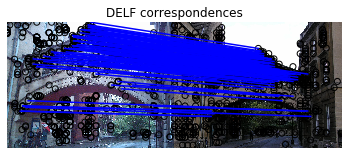

In [8]:
# Visualize correspondences, and save to file.
_, ax = plt.subplots()
img_1 = mpimg.imread(image_1_path)
img_2 = mpimg.imread(image_2_path)
inlier_idxs = np.nonzero(inliers)[0]
plot_matches(
  ax,
  img_1,
  img_2,
  locations_1_to_use,
  locations_2_to_use,
  np.column_stack((inlier_idxs, inlier_idxs)),
  matches_color='b')
ax.axis('off')
ax.set_title('DELF correspondences')
#plt.savefig(cmd_args.output_image)

## Match a query to the database

In [9]:
database = 'oxford5k'
database_root_path = '/home/tung/playground/data/oxford5k/'
database_image_path = os.path.join(database_root_path, 'oxford5k_images')
database_delf_path = os.path.join(database_root_path, 'oxford5k_features')

In [10]:
# Check if database_path exists
if not os.path.isdir(database_image_path):
    print("Database does NOT exists! Please verify!")
else:
    print("Database exists!")

Database exists!


In [11]:
def get_db_image_paths(destfolder):
    return sorted(list(glob.iglob(os.path.join(destfolder, '*.[Jj][Pp][Gg]'))))

In [12]:
db_images = get_db_image_paths(database_image_path)
db_images

# Write to a file to compute delf features if needed
#with open('image_list_path.txt', 'w') as f:
#    f.writelines("%s\n" % path for path in _list)

['/home/tung/playground/data/oxford5k/oxford5k_images/all_souls_000000.jpg',
 '/home/tung/playground/data/oxford5k/oxford5k_images/all_souls_000001.jpg',
 '/home/tung/playground/data/oxford5k/oxford5k_images/all_souls_000002.jpg',
 '/home/tung/playground/data/oxford5k/oxford5k_images/all_souls_000003.jpg',
 '/home/tung/playground/data/oxford5k/oxford5k_images/all_souls_000005.jpg',
 '/home/tung/playground/data/oxford5k/oxford5k_images/all_souls_000006.jpg',
 '/home/tung/playground/data/oxford5k/oxford5k_images/all_souls_000007.jpg',
 '/home/tung/playground/data/oxford5k/oxford5k_images/all_souls_000008.jpg',
 '/home/tung/playground/data/oxford5k/oxford5k_images/all_souls_000010.jpg',
 '/home/tung/playground/data/oxford5k/oxford5k_images/all_souls_000011.jpg',
 '/home/tung/playground/data/oxford5k/oxford5k_images/all_souls_000012.jpg',
 '/home/tung/playground/data/oxford5k/oxford5k_images/all_souls_000013.jpg',
 '/home/tung/playground/data/oxford5k/oxford5k_images/all_souls_000014.jpg',

### Aggregate all database images' locations and descriptors to lists
Calculate accumulated/aggregated indexes boundaries per image so we can reverse search the image index given an accumulated/aggregated index.

In [13]:
results_dict = {}

In [16]:
for image_path in db_images:
    features_path = image_path.replace('images', 'features').replace('jpg', 'delf')
    #print(features_path)
    locations, _, descriptors, _, _ = feature_io.ReadFromFile(features_path)
    num_features = locations.shape[0]
    tf.logging.info("Loaded image {}'s {} features".format(os.path.basename(image_path), num_features))
    results_dict[image_path] = [locations, descriptors]   

INFO:tensorflow:Loaded image all_souls_000000.jpg's 1000 features
INFO:tensorflow:Loaded image all_souls_000001.jpg's 1000 features
INFO:tensorflow:Loaded image all_souls_000002.jpg's 1000 features
INFO:tensorflow:Loaded image all_souls_000003.jpg's 1000 features
INFO:tensorflow:Loaded image all_souls_000005.jpg's 908 features
INFO:tensorflow:Loaded image all_souls_000006.jpg's 1000 features
INFO:tensorflow:Loaded image all_souls_000007.jpg's 1000 features
INFO:tensorflow:Loaded image all_souls_000008.jpg's 1000 features
INFO:tensorflow:Loaded image all_souls_000010.jpg's 1000 features
INFO:tensorflow:Loaded image all_souls_000011.jpg's 1000 features
INFO:tensorflow:Loaded image all_souls_000012.jpg's 1000 features
INFO:tensorflow:Loaded image all_souls_000013.jpg's 1000 features
INFO:tensorflow:Loaded image all_souls_000014.jpg's 1000 features
INFO:tensorflow:Loaded image all_souls_000015.jpg's 1000 features
INFO:tensorflow:Loaded image all_souls_000016.jpg's 1000 features
INFO:tensor

INFO:tensorflow:Loaded image all_souls_000210.jpg's 1000 features
INFO:tensorflow:Loaded image all_souls_000213.jpg's 1000 features
INFO:tensorflow:Loaded image all_souls_000214.jpg's 1000 features
INFO:tensorflow:Loaded image all_souls_000215.jpg's 1000 features
INFO:tensorflow:Loaded image all_souls_000216.jpg's 1000 features
INFO:tensorflow:Loaded image all_souls_000219.jpg's 1000 features
INFO:tensorflow:Loaded image all_souls_000220.jpg's 1000 features
INFO:tensorflow:Loaded image ashmolean_000000.jpg's 1000 features
INFO:tensorflow:Loaded image ashmolean_000002.jpg's 1000 features
INFO:tensorflow:Loaded image ashmolean_000003.jpg's 1000 features
INFO:tensorflow:Loaded image ashmolean_000005.jpg's 1000 features
INFO:tensorflow:Loaded image ashmolean_000007.jpg's 1000 features
INFO:tensorflow:Loaded image ashmolean_000010.jpg's 299 features
INFO:tensorflow:Loaded image ashmolean_000012.jpg's 525 features
INFO:tensorflow:Loaded image ashmolean_000014.jpg's 944 features
INFO:tensorfl

INFO:tensorflow:Loaded image ashmolean_000225.jpg's 1000 features
INFO:tensorflow:Loaded image ashmolean_000227.jpg's 220 features
INFO:tensorflow:Loaded image ashmolean_000228.jpg's 590 features
INFO:tensorflow:Loaded image ashmolean_000229.jpg's 1000 features
INFO:tensorflow:Loaded image ashmolean_000230.jpg's 1000 features
INFO:tensorflow:Loaded image ashmolean_000231.jpg's 1000 features
INFO:tensorflow:Loaded image ashmolean_000232.jpg's 1000 features
INFO:tensorflow:Loaded image ashmolean_000233.jpg's 620 features
INFO:tensorflow:Loaded image ashmolean_000236.jpg's 776 features
INFO:tensorflow:Loaded image ashmolean_000241.jpg's 1000 features
INFO:tensorflow:Loaded image ashmolean_000242.jpg's 1000 features
INFO:tensorflow:Loaded image ashmolean_000243.jpg's 722 features
INFO:tensorflow:Loaded image ashmolean_000244.jpg's 1000 features
INFO:tensorflow:Loaded image ashmolean_000245.jpg's 772 features
INFO:tensorflow:Loaded image ashmolean_000246.jpg's 1000 features
INFO:tensorflow:

INFO:tensorflow:Loaded image balliol_000062.jpg's 1000 features
INFO:tensorflow:Loaded image balliol_000064.jpg's 1000 features
INFO:tensorflow:Loaded image balliol_000065.jpg's 1000 features
INFO:tensorflow:Loaded image balliol_000066.jpg's 1000 features
INFO:tensorflow:Loaded image balliol_000067.jpg's 191 features
INFO:tensorflow:Loaded image balliol_000069.jpg's 334 features
INFO:tensorflow:Loaded image balliol_000071.jpg's 532 features
INFO:tensorflow:Loaded image balliol_000073.jpg's 1000 features
INFO:tensorflow:Loaded image balliol_000075.jpg's 1000 features
INFO:tensorflow:Loaded image balliol_000077.jpg's 530 features
INFO:tensorflow:Loaded image balliol_000078.jpg's 540 features
INFO:tensorflow:Loaded image balliol_000079.jpg's 1000 features
INFO:tensorflow:Loaded image balliol_000080.jpg's 1000 features
INFO:tensorflow:Loaded image balliol_000081.jpg's 569 features
INFO:tensorflow:Loaded image balliol_000082.jpg's 359 features
INFO:tensorflow:Loaded image balliol_000083.jpg

INFO:tensorflow:Loaded image bodleian_000052.jpg's 630 features
INFO:tensorflow:Loaded image bodleian_000056.jpg's 1000 features
INFO:tensorflow:Loaded image bodleian_000058.jpg's 1000 features
INFO:tensorflow:Loaded image bodleian_000060.jpg's 1000 features
INFO:tensorflow:Loaded image bodleian_000061.jpg's 829 features
INFO:tensorflow:Loaded image bodleian_000062.jpg's 1000 features
INFO:tensorflow:Loaded image bodleian_000067.jpg's 1000 features
INFO:tensorflow:Loaded image bodleian_000069.jpg's 1000 features
INFO:tensorflow:Loaded image bodleian_000070.jpg's 1000 features
INFO:tensorflow:Loaded image bodleian_000072.jpg's 1000 features
INFO:tensorflow:Loaded image bodleian_000073.jpg's 1000 features
INFO:tensorflow:Loaded image bodleian_000076.jpg's 1000 features
INFO:tensorflow:Loaded image bodleian_000077.jpg's 1000 features
INFO:tensorflow:Loaded image bodleian_000081.jpg's 1000 features
INFO:tensorflow:Loaded image bodleian_000083.jpg's 1000 features
INFO:tensorflow:Loaded imag

INFO:tensorflow:Loaded image bodleian_000364.jpg's 1000 features
INFO:tensorflow:Loaded image bodleian_000365.jpg's 945 features
INFO:tensorflow:Loaded image bodleian_000366.jpg's 479 features
INFO:tensorflow:Loaded image bodleian_000367.jpg's 1000 features
INFO:tensorflow:Loaded image bodleian_000368.jpg's 1000 features
INFO:tensorflow:Loaded image bodleian_000370.jpg's 1000 features
INFO:tensorflow:Loaded image bodleian_000371.jpg's 897 features
INFO:tensorflow:Loaded image bodleian_000375.jpg's 1000 features
INFO:tensorflow:Loaded image bodleian_000376.jpg's 1000 features
INFO:tensorflow:Loaded image bodleian_000377.jpg's 1000 features
INFO:tensorflow:Loaded image bodleian_000378.jpg's 989 features
INFO:tensorflow:Loaded image bodleian_000379.jpg's 1000 features
INFO:tensorflow:Loaded image bodleian_000380.jpg's 1000 features
INFO:tensorflow:Loaded image bodleian_000381.jpg's 1000 features
INFO:tensorflow:Loaded image bodleian_000382.jpg's 1000 features
INFO:tensorflow:Loaded image 

INFO:tensorflow:Loaded image christ_church_000129.jpg's 1000 features
INFO:tensorflow:Loaded image christ_church_000130.jpg's 1000 features
INFO:tensorflow:Loaded image christ_church_000131.jpg's 1000 features
INFO:tensorflow:Loaded image christ_church_000132.jpg's 1000 features
INFO:tensorflow:Loaded image christ_church_000133.jpg's 1000 features
INFO:tensorflow:Loaded image christ_church_000134.jpg's 703 features
INFO:tensorflow:Loaded image christ_church_000135.jpg's 1000 features
INFO:tensorflow:Loaded image christ_church_000136.jpg's 1000 features
INFO:tensorflow:Loaded image christ_church_000137.jpg's 1000 features
INFO:tensorflow:Loaded image christ_church_000138.jpg's 1000 features
INFO:tensorflow:Loaded image christ_church_000139.jpg's 1000 features
INFO:tensorflow:Loaded image christ_church_000140.jpg's 1000 features
INFO:tensorflow:Loaded image christ_church_000141.jpg's 577 features
INFO:tensorflow:Loaded image christ_church_000142.jpg's 719 features
INFO:tensorflow:Loaded 

INFO:tensorflow:Loaded image christ_church_000326.jpg's 953 features
INFO:tensorflow:Loaded image christ_church_000327.jpg's 1000 features
INFO:tensorflow:Loaded image christ_church_000329.jpg's 1000 features
INFO:tensorflow:Loaded image christ_church_000330.jpg's 1000 features
INFO:tensorflow:Loaded image christ_church_000331.jpg's 1000 features
INFO:tensorflow:Loaded image christ_church_000333.jpg's 1000 features
INFO:tensorflow:Loaded image christ_church_000336.jpg's 1000 features
INFO:tensorflow:Loaded image christ_church_000337.jpg's 1000 features
INFO:tensorflow:Loaded image christ_church_000338.jpg's 1000 features
INFO:tensorflow:Loaded image christ_church_000339.jpg's 1000 features
INFO:tensorflow:Loaded image christ_church_000340.jpg's 1000 features
INFO:tensorflow:Loaded image christ_church_000341.jpg's 781 features
INFO:tensorflow:Loaded image christ_church_000342.jpg's 632 features
INFO:tensorflow:Loaded image christ_church_000343.jpg's 1000 features
INFO:tensorflow:Loaded 

INFO:tensorflow:Loaded image christ_church_000586.jpg's 1000 features
INFO:tensorflow:Loaded image christ_church_000587.jpg's 1000 features
INFO:tensorflow:Loaded image christ_church_000589.jpg's 1000 features
INFO:tensorflow:Loaded image christ_church_000592.jpg's 1000 features
INFO:tensorflow:Loaded image christ_church_000593.jpg's 513 features
INFO:tensorflow:Loaded image christ_church_000596.jpg's 1000 features
INFO:tensorflow:Loaded image christ_church_000598.jpg's 608 features
INFO:tensorflow:Loaded image christ_church_000599.jpg's 1000 features
INFO:tensorflow:Loaded image christ_church_000602.jpg's 1000 features
INFO:tensorflow:Loaded image christ_church_000612.jpg's 1000 features
INFO:tensorflow:Loaded image christ_church_000619.jpg's 1000 features
INFO:tensorflow:Loaded image christ_church_000623.jpg's 1000 features
INFO:tensorflow:Loaded image christ_church_000626.jpg's 1000 features
INFO:tensorflow:Loaded image christ_church_000627.jpg's 1000 features
INFO:tensorflow:Loaded

INFO:tensorflow:Loaded image christ_church_000871.jpg's 593 features
INFO:tensorflow:Loaded image christ_church_000873.jpg's 1000 features
INFO:tensorflow:Loaded image christ_church_000884.jpg's 1000 features
INFO:tensorflow:Loaded image christ_church_000885.jpg's 1000 features
INFO:tensorflow:Loaded image christ_church_000886.jpg's 1000 features
INFO:tensorflow:Loaded image christ_church_000889.jpg's 686 features
INFO:tensorflow:Loaded image christ_church_000891.jpg's 939 features
INFO:tensorflow:Loaded image christ_church_000892.jpg's 1000 features
INFO:tensorflow:Loaded image christ_church_000895.jpg's 884 features
INFO:tensorflow:Loaded image christ_church_000896.jpg's 1000 features
INFO:tensorflow:Loaded image christ_church_000897.jpg's 1000 features
INFO:tensorflow:Loaded image christ_church_000898.jpg's 830 features
INFO:tensorflow:Loaded image christ_church_000900.jpg's 399 features
INFO:tensorflow:Loaded image christ_church_000901.jpg's 1000 features
INFO:tensorflow:Loaded ima

INFO:tensorflow:Loaded image christ_church_001113.jpg's 1000 features
INFO:tensorflow:Loaded image christ_church_001114.jpg's 1000 features
INFO:tensorflow:Loaded image christ_church_001121.jpg's 1000 features
INFO:tensorflow:Loaded image christ_church_001124.jpg's 1000 features
INFO:tensorflow:Loaded image christ_church_001126.jpg's 1000 features
INFO:tensorflow:Loaded image christ_church_001136.jpg's 1000 features
INFO:tensorflow:Loaded image christ_church_001142.jpg's 1000 features
INFO:tensorflow:Loaded image christ_church_001143.jpg's 970 features
INFO:tensorflow:Loaded image christ_church_001149.jpg's 443 features
INFO:tensorflow:Loaded image christ_church_001158.jpg's 655 features
INFO:tensorflow:Loaded image cornmarket_000004.jpg's 1000 features
INFO:tensorflow:Loaded image cornmarket_000016.jpg's 410 features
INFO:tensorflow:Loaded image cornmarket_000017.jpg's 1000 features
INFO:tensorflow:Loaded image cornmarket_000018.jpg's 500 features
INFO:tensorflow:Loaded image cornmark

INFO:tensorflow:Loaded image hertford_000111.jpg's 1000 features
INFO:tensorflow:Loaded image hertford_000112.jpg's 1000 features
INFO:tensorflow:Loaded image hertford_000116.jpg's 1000 features
INFO:tensorflow:Loaded image hertford_000118.jpg's 528 features
INFO:tensorflow:Loaded image hertford_000119.jpg's 1000 features
INFO:tensorflow:Loaded image hertford_000121.jpg's 1000 features
INFO:tensorflow:Loaded image hertford_000123.jpg's 1000 features
INFO:tensorflow:Loaded image hertford_000127.jpg's 633 features
INFO:tensorflow:Loaded image hertford_000128.jpg's 367 features
INFO:tensorflow:Loaded image hertford_000131.jpg's 472 features
INFO:tensorflow:Loaded image hertford_000133.jpg's 340 features
INFO:tensorflow:Loaded image jesus_000000.jpg's 638 features
INFO:tensorflow:Loaded image jesus_000001.jpg's 905 features
INFO:tensorflow:Loaded image jesus_000002.jpg's 1000 features
INFO:tensorflow:Loaded image jesus_000003.jpg's 856 features
INFO:tensorflow:Loaded image jesus_000004.jpg

INFO:tensorflow:Loaded image jesus_000332.jpg's 880 features
INFO:tensorflow:Loaded image jesus_000333.jpg's 959 features
INFO:tensorflow:Loaded image jesus_000334.jpg's 1000 features
INFO:tensorflow:Loaded image jesus_000335.jpg's 1000 features
INFO:tensorflow:Loaded image jesus_000336.jpg's 1000 features
INFO:tensorflow:Loaded image jesus_000337.jpg's 252 features
INFO:tensorflow:Loaded image jesus_000343.jpg's 399 features
INFO:tensorflow:Loaded image jesus_000345.jpg's 1000 features
INFO:tensorflow:Loaded image jesus_000346.jpg's 777 features
INFO:tensorflow:Loaded image jesus_000348.jpg's 1000 features
INFO:tensorflow:Loaded image jesus_000350.jpg's 302 features
INFO:tensorflow:Loaded image jesus_000351.jpg's 1000 features
INFO:tensorflow:Loaded image jesus_000353.jpg's 1000 features
INFO:tensorflow:Loaded image jesus_000355.jpg's 915 features
INFO:tensorflow:Loaded image jesus_000356.jpg's 1000 features
INFO:tensorflow:Loaded image jesus_000357.jpg's 1000 features
INFO:tensorflow

INFO:tensorflow:Loaded image keble_000212.jpg's 1000 features
INFO:tensorflow:Loaded image keble_000213.jpg's 1000 features
INFO:tensorflow:Loaded image keble_000214.jpg's 1000 features
INFO:tensorflow:Loaded image keble_000215.jpg's 1000 features
INFO:tensorflow:Loaded image keble_000223.jpg's 379 features
INFO:tensorflow:Loaded image keble_000227.jpg's 1000 features
INFO:tensorflow:Loaded image keble_000228.jpg's 1000 features
INFO:tensorflow:Loaded image keble_000230.jpg's 1000 features
INFO:tensorflow:Loaded image keble_000231.jpg's 835 features
INFO:tensorflow:Loaded image keble_000232.jpg's 1000 features
INFO:tensorflow:Loaded image keble_000233.jpg's 1000 features
INFO:tensorflow:Loaded image keble_000234.jpg's 1000 features
INFO:tensorflow:Loaded image keble_000237.jpg's 337 features
INFO:tensorflow:Loaded image keble_000238.jpg's 1000 features
INFO:tensorflow:Loaded image keble_000241.jpg's 1000 features
INFO:tensorflow:Loaded image keble_000242.jpg's 1000 features
INFO:tensor

INFO:tensorflow:Loaded image magdalen_000162.jpg's 1000 features
INFO:tensorflow:Loaded image magdalen_000163.jpg's 836 features
INFO:tensorflow:Loaded image magdalen_000164.jpg's 1000 features
INFO:tensorflow:Loaded image magdalen_000165.jpg's 830 features
INFO:tensorflow:Loaded image magdalen_000167.jpg's 798 features
INFO:tensorflow:Loaded image magdalen_000169.jpg's 618 features
INFO:tensorflow:Loaded image magdalen_000171.jpg's 741 features
INFO:tensorflow:Loaded image magdalen_000172.jpg's 753 features
INFO:tensorflow:Loaded image magdalen_000173.jpg's 600 features
INFO:tensorflow:Loaded image magdalen_000174.jpg's 924 features
INFO:tensorflow:Loaded image magdalen_000175.jpg's 867 features
INFO:tensorflow:Loaded image magdalen_000176.jpg's 340 features
INFO:tensorflow:Loaded image magdalen_000177.jpg's 431 features
INFO:tensorflow:Loaded image magdalen_000178.jpg's 1000 features
INFO:tensorflow:Loaded image magdalen_000179.jpg's 985 features
INFO:tensorflow:Loaded image magdalen

INFO:tensorflow:Loaded image magdalen_000319.jpg's 463 features
INFO:tensorflow:Loaded image magdalen_000320.jpg's 1000 features
INFO:tensorflow:Loaded image magdalen_000325.jpg's 539 features
INFO:tensorflow:Loaded image magdalen_000328.jpg's 1000 features
INFO:tensorflow:Loaded image magdalen_000330.jpg's 540 features
INFO:tensorflow:Loaded image magdalen_000332.jpg's 1000 features
INFO:tensorflow:Loaded image magdalen_000334.jpg's 1000 features
INFO:tensorflow:Loaded image magdalen_000335.jpg's 1000 features
INFO:tensorflow:Loaded image magdalen_000338.jpg's 997 features
INFO:tensorflow:Loaded image magdalen_000339.jpg's 1000 features
INFO:tensorflow:Loaded image magdalen_000340.jpg's 786 features
INFO:tensorflow:Loaded image magdalen_000343.jpg's 593 features
INFO:tensorflow:Loaded image magdalen_000349.jpg's 1000 features
INFO:tensorflow:Loaded image magdalen_000353.jpg's 854 features
INFO:tensorflow:Loaded image magdalen_000358.jpg's 1000 features
INFO:tensorflow:Loaded image mag

INFO:tensorflow:Loaded image magdalen_000576.jpg's 1000 features
INFO:tensorflow:Loaded image magdalen_000577.jpg's 1000 features
INFO:tensorflow:Loaded image magdalen_000579.jpg's 993 features
INFO:tensorflow:Loaded image magdalen_000582.jpg's 900 features
INFO:tensorflow:Loaded image magdalen_000585.jpg's 955 features
INFO:tensorflow:Loaded image magdalen_000588.jpg's 1000 features
INFO:tensorflow:Loaded image magdalen_000591.jpg's 620 features
INFO:tensorflow:Loaded image magdalen_000592.jpg's 886 features
INFO:tensorflow:Loaded image magdalen_000595.jpg's 1000 features
INFO:tensorflow:Loaded image magdalen_000596.jpg's 1000 features
INFO:tensorflow:Loaded image magdalen_000597.jpg's 668 features
INFO:tensorflow:Loaded image magdalen_000599.jpg's 419 features
INFO:tensorflow:Loaded image magdalen_000600.jpg's 687 features
INFO:tensorflow:Loaded image magdalen_000601.jpg's 1000 features
INFO:tensorflow:Loaded image magdalen_000602.jpg's 1000 features
INFO:tensorflow:Loaded image magd

INFO:tensorflow:Loaded image magdalen_000763.jpg's 1000 features
INFO:tensorflow:Loaded image magdalen_000764.jpg's 1000 features
INFO:tensorflow:Loaded image magdalen_000765.jpg's 898 features
INFO:tensorflow:Loaded image magdalen_000767.jpg's 481 features
INFO:tensorflow:Loaded image magdalen_000774.jpg's 1000 features
INFO:tensorflow:Loaded image magdalen_000775.jpg's 1000 features
INFO:tensorflow:Loaded image magdalen_000776.jpg's 935 features
INFO:tensorflow:Loaded image magdalen_000777.jpg's 498 features
INFO:tensorflow:Loaded image magdalen_000781.jpg's 376 features
INFO:tensorflow:Loaded image magdalen_000783.jpg's 1000 features
INFO:tensorflow:Loaded image magdalen_000785.jpg's 373 features
INFO:tensorflow:Loaded image magdalen_000786.jpg's 1000 features
INFO:tensorflow:Loaded image magdalen_000790.jpg's 511 features
INFO:tensorflow:Loaded image magdalen_000792.jpg's 600 features
INFO:tensorflow:Loaded image magdalen_000796.jpg's 632 features
INFO:tensorflow:Loaded image magda

INFO:tensorflow:Loaded image magdalen_001035.jpg's 935 features
INFO:tensorflow:Loaded image magdalen_001036.jpg's 1000 features
INFO:tensorflow:Loaded image magdalen_001037.jpg's 297 features
INFO:tensorflow:Loaded image magdalen_001038.jpg's 309 features
INFO:tensorflow:Loaded image magdalen_001039.jpg's 1000 features
INFO:tensorflow:Loaded image magdalen_001040.jpg's 1000 features
INFO:tensorflow:Loaded image magdalen_001042.jpg's 1000 features
INFO:tensorflow:Loaded image magdalen_001043.jpg's 1000 features
INFO:tensorflow:Loaded image magdalen_001044.jpg's 358 features
INFO:tensorflow:Loaded image magdalen_001045.jpg's 978 features
INFO:tensorflow:Loaded image magdalen_001048.jpg's 1000 features
INFO:tensorflow:Loaded image magdalen_001049.jpg's 1000 features
INFO:tensorflow:Loaded image magdalen_001051.jpg's 300 features
INFO:tensorflow:Loaded image magdalen_001055.jpg's 1000 features
INFO:tensorflow:Loaded image magdalen_001056.jpg's 1000 features
INFO:tensorflow:Loaded image ma

INFO:tensorflow:Loaded image new_000185.jpg's 1000 features
INFO:tensorflow:Loaded image new_000192.jpg's 1000 features
INFO:tensorflow:Loaded image new_000197.jpg's 743 features
INFO:tensorflow:Loaded image new_000199.jpg's 1000 features
INFO:tensorflow:Loaded image new_000206.jpg's 1000 features
INFO:tensorflow:Loaded image new_000211.jpg's 853 features
INFO:tensorflow:Loaded image new_000216.jpg's 1000 features
INFO:tensorflow:Loaded image new_000222.jpg's 1000 features
INFO:tensorflow:Loaded image new_000223.jpg's 917 features
INFO:tensorflow:Loaded image new_000224.jpg's 769 features
INFO:tensorflow:Loaded image new_000225.jpg's 1000 features
INFO:tensorflow:Loaded image new_000226.jpg's 802 features
INFO:tensorflow:Loaded image new_000227.jpg's 1000 features
INFO:tensorflow:Loaded image new_000228.jpg's 1000 features
INFO:tensorflow:Loaded image new_000229.jpg's 1000 features
INFO:tensorflow:Loaded image new_000230.jpg's 1000 features
INFO:tensorflow:Loaded image new_000233.jpg's

INFO:tensorflow:Loaded image new_000468.jpg's 481 features
INFO:tensorflow:Loaded image new_000469.jpg's 691 features
INFO:tensorflow:Loaded image new_000473.jpg's 756 features
INFO:tensorflow:Loaded image new_000474.jpg's 664 features
INFO:tensorflow:Loaded image new_000475.jpg's 926 features
INFO:tensorflow:Loaded image new_000476.jpg's 762 features
INFO:tensorflow:Loaded image new_000477.jpg's 553 features
INFO:tensorflow:Loaded image new_000479.jpg's 718 features
INFO:tensorflow:Loaded image new_000480.jpg's 497 features
INFO:tensorflow:Loaded image new_000481.jpg's 1000 features
INFO:tensorflow:Loaded image new_000482.jpg's 435 features
INFO:tensorflow:Loaded image new_000483.jpg's 1000 features
INFO:tensorflow:Loaded image new_000484.jpg's 528 features
INFO:tensorflow:Loaded image new_000485.jpg's 408 features
INFO:tensorflow:Loaded image new_000486.jpg's 450 features
INFO:tensorflow:Loaded image new_000487.jpg's 602 features
INFO:tensorflow:Loaded image new_000488.jpg's 648 feat

INFO:tensorflow:Loaded image new_000866.jpg's 690 features
INFO:tensorflow:Loaded image new_000867.jpg's 805 features
INFO:tensorflow:Loaded image new_000874.jpg's 1000 features
INFO:tensorflow:Loaded image new_000876.jpg's 1000 features
INFO:tensorflow:Loaded image new_000877.jpg's 668 features
INFO:tensorflow:Loaded image new_000878.jpg's 651 features
INFO:tensorflow:Loaded image new_000879.jpg's 302 features
INFO:tensorflow:Loaded image new_000880.jpg's 776 features
INFO:tensorflow:Loaded image new_000881.jpg's 336 features
INFO:tensorflow:Loaded image new_000882.jpg's 1000 features
INFO:tensorflow:Loaded image new_000883.jpg's 1000 features
INFO:tensorflow:Loaded image new_000884.jpg's 532 features
INFO:tensorflow:Loaded image new_000889.jpg's 1000 features
INFO:tensorflow:Loaded image new_000890.jpg's 1000 features
INFO:tensorflow:Loaded image new_000891.jpg's 772 features
INFO:tensorflow:Loaded image new_000898.jpg's 1000 features
INFO:tensorflow:Loaded image new_000899.jpg's 558

INFO:tensorflow:Loaded image oriel_000024.jpg's 879 features
INFO:tensorflow:Loaded image oriel_000026.jpg's 1000 features
INFO:tensorflow:Loaded image oriel_000028.jpg's 1000 features
INFO:tensorflow:Loaded image oriel_000029.jpg's 1000 features
INFO:tensorflow:Loaded image oriel_000030.jpg's 419 features
INFO:tensorflow:Loaded image oriel_000031.jpg's 403 features
INFO:tensorflow:Loaded image oriel_000033.jpg's 1000 features
INFO:tensorflow:Loaded image oriel_000034.jpg's 439 features
INFO:tensorflow:Loaded image oriel_000035.jpg's 1000 features
INFO:tensorflow:Loaded image oriel_000036.jpg's 1000 features
INFO:tensorflow:Loaded image oriel_000037.jpg's 1000 features
INFO:tensorflow:Loaded image oriel_000038.jpg's 384 features
INFO:tensorflow:Loaded image oriel_000039.jpg's 592 features
INFO:tensorflow:Loaded image oriel_000040.jpg's 990 features
INFO:tensorflow:Loaded image oriel_000041.jpg's 152 features
INFO:tensorflow:Loaded image oriel_000042.jpg's 1000 features
INFO:tensorflow:

INFO:tensorflow:Loaded image oxford_000113.jpg's 1000 features
INFO:tensorflow:Loaded image oxford_000114.jpg's 1000 features
INFO:tensorflow:Loaded image oxford_000119.jpg's 389 features
INFO:tensorflow:Loaded image oxford_000125.jpg's 1000 features
INFO:tensorflow:Loaded image oxford_000128.jpg's 1000 features
INFO:tensorflow:Loaded image oxford_000129.jpg's 1000 features
INFO:tensorflow:Loaded image oxford_000130.jpg's 1000 features
INFO:tensorflow:Loaded image oxford_000132.jpg's 1000 features
INFO:tensorflow:Loaded image oxford_000133.jpg's 1000 features
INFO:tensorflow:Loaded image oxford_000135.jpg's 1000 features
INFO:tensorflow:Loaded image oxford_000137.jpg's 1000 features
INFO:tensorflow:Loaded image oxford_000138.jpg's 1000 features
INFO:tensorflow:Loaded image oxford_000142.jpg's 529 features
INFO:tensorflow:Loaded image oxford_000144.jpg's 1000 features
INFO:tensorflow:Loaded image oxford_000155.jpg's 1000 features
INFO:tensorflow:Loaded image oxford_000158.jpg's 1000 fea

INFO:tensorflow:Loaded image oxford_000478.jpg's 1000 features
INFO:tensorflow:Loaded image oxford_000480.jpg's 1000 features
INFO:tensorflow:Loaded image oxford_000481.jpg's 738 features
INFO:tensorflow:Loaded image oxford_000486.jpg's 1000 features
INFO:tensorflow:Loaded image oxford_000487.jpg's 1000 features
INFO:tensorflow:Loaded image oxford_000490.jpg's 894 features
INFO:tensorflow:Loaded image oxford_000493.jpg's 849 features
INFO:tensorflow:Loaded image oxford_000494.jpg's 1000 features
INFO:tensorflow:Loaded image oxford_000496.jpg's 1000 features
INFO:tensorflow:Loaded image oxford_000499.jpg's 289 features
INFO:tensorflow:Loaded image oxford_000502.jpg's 1000 features
INFO:tensorflow:Loaded image oxford_000503.jpg's 1000 features
INFO:tensorflow:Loaded image oxford_000504.jpg's 979 features
INFO:tensorflow:Loaded image oxford_000511.jpg's 663 features
INFO:tensorflow:Loaded image oxford_000518.jpg's 1000 features
INFO:tensorflow:Loaded image oxford_000519.jpg's 1000 feature

INFO:tensorflow:Loaded image oxford_000765.jpg's 785 features
INFO:tensorflow:Loaded image oxford_000766.jpg's 1000 features
INFO:tensorflow:Loaded image oxford_000768.jpg's 393 features
INFO:tensorflow:Loaded image oxford_000769.jpg's 988 features
INFO:tensorflow:Loaded image oxford_000770.jpg's 960 features
INFO:tensorflow:Loaded image oxford_000773.jpg's 1000 features
INFO:tensorflow:Loaded image oxford_000774.jpg's 1000 features
INFO:tensorflow:Loaded image oxford_000780.jpg's 1000 features
INFO:tensorflow:Loaded image oxford_000781.jpg's 1000 features
INFO:tensorflow:Loaded image oxford_000783.jpg's 733 features
INFO:tensorflow:Loaded image oxford_000785.jpg's 1000 features
INFO:tensorflow:Loaded image oxford_000789.jpg's 1000 features
INFO:tensorflow:Loaded image oxford_000803.jpg's 1000 features
INFO:tensorflow:Loaded image oxford_000805.jpg's 1000 features
INFO:tensorflow:Loaded image oxford_000808.jpg's 1000 features
INFO:tensorflow:Loaded image oxford_000809.jpg's 1000 featur

KeyboardInterrupt: 

In [21]:
locations_agg = np.concatenate([results_dict[img][0] for img in db_images])
descriptors_agg = np.concatenate([results_dict[img][1] for img in db_images])
accumulated_indexes_boundaries = list(accumulate([results_dict[img][0].shape[0] for img in db_images]))

KeyError: '/home/tung/playground/data/oxford5k/oxford5k_images/oxford_002295.jpg'

In [ ]:
locations_agg

### Build KD tree with database images' descriptors

In [ ]:
d_tree = cKDTree(descriptors_agg) # build the KD tree

## Query a new image

In [ ]:
 # Query
image_1_path = '/home/tung/playground/data/oxford5k/oxford5k_images/oxford_000317.jpg'
features_1_path = '/home/tung/playground/data/oxford5k/oxford5k_features/oxford_000317.delf' #oxford_000773.delf'
# Read query's features 
locations_1, _, descriptors_1, _, _ = feature_io.ReadFromFile(features_1_path)
num_features_1 = locations_1.shape[0]
tf.logging.info("Loaded image 1's %d features" % num_features_1)

In [ ]:
query_image = '/home/tung/playground/delf_instance_retrieval/delf/delf/python/examples/images/IMG_0818.JPG'
def preprocess_query_image(imagepath):
    '''
    Resize the query image and return the resized image path.
    '''
    query_temp_folder_name = 'query_temp_folder'
    query_temp_folder = os.path.join(os.path.dirname(query_image), query_temp_folder_name)
    os.makedirs(query_temp_folder,exist_ok=True)
    query_basename = os.path.basename(query_image)
    destfile=os.path.join(query_temp_folder,query_basename)
    resized_image = resize_image(query_image, destfile)
    return resized_image

resized_image = preprocess_query_image(query_image)

In [ ]:
query_image_locations, query_image_descriptors = compute_locations_and_descriptors(resized_image)

### Query the KD tree to find K nearest neighbors for each descriptor

In [ ]:
distance_threshold = 0.8
# K nearest neighbors
K = 10
distances, indices = d_tree.query(
    query_image_descriptors, distance_upper_bound=distance_threshold, k = K, n_jobs=-1)

# Find the list of unique accumulated/aggregated indexes
unique_indices = np.array(list(set(indices.flatten())))

unique_indices.sort()
if unique_indices[-1] == descriptors_agg.shape[0]:
    unique_indices = unique_indices[:-1]

## Get a list of database candidate image indexes
Look up a list of unique image indexes, each image contains at least one of K nearest neighbor result descriptors.
By reverse indexes look up.

In [ ]:
unique_image_indexes = np.array(
    list(set([np.argmax([np.array(accumulated_indexes_boundaries)>index]) 
              for index in unique_indices])))
unique_image_indexes

In [ ]:
def image_index_2_accumulated_indexes(index, accumulated_indexes_boundaries):
    '''
    Image index to accumulated/aggregated locations/descriptors pair indexes.
    '''
    if index > len(accumulated_indexes_boundaries) - 1:
        return None
    accumulated_index_start = None
    accumulated_index_end = None
    if index == 0:
        accumulated_index_start = 0
        accumulated_index_end = accumulated_indexes_boundaries[index]
    else:
        accumulated_index_start = accumulated_indexes_boundaries[index-1]
        accumulated_index_end = accumulated_indexes_boundaries[index]
    return np.arange(accumulated_index_start,accumulated_index_end)

In [ ]:
def get_locations_2_use(image_db_index, k_nearest_indices, accumulated_indexes_boundaries):
    '''
    Get a pair of locations to use, the query image to the database image with given index.
    Return: a tuple of 2 numpy arrays, the locations pair.
    '''
    image_accumulated_indexes = image_index_2_accumulated_indexes(image_db_index, accumulated_indexes_boundaries)
    locations_2_use_query = []
    locations_2_use_db = []
    for i, row in enumerate(k_nearest_indices):
        for acc_index in row:
            if acc_index in image_accumulated_indexes:
                locations_2_use_query.append(query_image_locations[i])
                locations_2_use_db.append(locations_agg[acc_index])
                break
    return np.array(locations_2_use_query), np.array(locations_2_use_db)
            

### Perform geometric verification using RANSAC and visualization

In [ ]:
# Array to keep track of all candidates in database.
inliers_counts = []
# Read the resized query image for plotting.
img_1 = mpimg.imread(resized_image)
for index in unique_image_indexes:
    locations_2_use_query, locations_2_use_db = get_locations_2_use(index, indices, accumulated_indexes_boundaries)
    # Perform geometric verification using RANSAC.
    _, inliers = ransac(
        (locations_2_use_db, locations_2_use_query), # source and destination coordinates
        AffineTransform,
        min_samples=3,
        residual_threshold=20,
        max_trials=1000)
    # If no inlier is found for a database candidate image, we continue on to the next one.
    if inliers is None or len(inliers) == 0:
        continue
    # the number of inliers as the score for retrieved images.
    inliers_counts.append({"index": index, "inliers": sum(inliers)})
    print('Found inliers for image {} -> {}'.format(index, sum(inliers)))
    # Visualize correspondences.
    _, ax = plt.subplots()
    img_2 = mpimg.imread(db_images[index])
    inlier_idxs = np.nonzero(inliers)[0]
    plot_matches(
        ax,
        img_1,
        img_2,
        locations_2_use_db,
        locations_2_use_query,
        np.column_stack((inlier_idxs, inlier_idxs)),
        matches_color='b')
    ax.axis('off')
    ax.set_title('DELF correspondences')
    plt.show()

In [ ]:
inliers_counts

### Show the top match result
Employ the number of inliers as the score for retrieved images.

In [ ]:
top_match = sorted(inliers_counts, key=lambda k: k['inliers'], reverse=True)[0]

index = top_match['index']
#print('Best guess for this image:', building_descs[index])
locations_2_use_query, locations_2_use_db = get_locations_2_use(index, indices, accumulated_indexes_boundaries)
# Perform geometric verification using RANSAC.
_, inliers = ransac(
    (locations_2_use_db, locations_2_use_query), # source and destination coordinates
    AffineTransform,
    min_samples=3,
    residual_threshold=20,
    max_trials=1000)
# Visualize correspondences.
_, ax = plt.subplots()
img_2 = mpimg.imread(db_images[index])
inlier_idxs = np.nonzero(inliers)[0]
plot_matches(
    ax,
    img_1,
    img_2,
    locations_2_use_db,
    locations_2_use_query,
    np.column_stack((inlier_idxs, inlier_idxs)),
    matches_color='b')
ax.axis('off')
ax.set_title('DELF correspondences')
plt.show()

In [ ]:
import pandas as pd
df = pd.DataFrame(np.unique(locations_agg, axis=0), columns=['x', 'y'])
df.head()

In [ ]:
fig, axe = plt.subplots(ncols=1, figsize = (6,6))
df.plot.scatter(x = 'x', y='y', fontsize=15, ax = axe)
axe.set_ylabel("y", size = 20)
axe.set_xlabel("x", size = 20)
plt.show()

In [ ]:
np.array(accumulated_indexes_boundaries)